In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

PAD_IDX = 0
UNK_IDX = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
train_id = np.load('id_train.npy')
test_id = np.load('id_test.npy')

In [5]:
lyrics = pd.read_csv(r'final_matrix.csv')

In [54]:
lyrics_train = lyrics[lyrics.ISRC.isin(train_id)]
lyrics_test = lyrics[lyrics.ISRC.isin(test_id)]

In [14]:
def load_emb_matrix():
    #load fasttext word vectors
    words_to_load = 50000

    with open('wiki-news-300d-1M-subword.vec') as f:
        #remove the first line
        firstLine = f.readline()
        loaded_embeddings = np.zeros((words_to_load + 2, 300))
        words2id = {}
        idx2words = {}
        #ordered_words = []
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split()
            loaded_embeddings[i + 2 , :] = np.asarray(s[1:])
            words2id['<pad>'] = PAD_IDX
            words2id['<unk>'] = UNK_IDX
            words2id[s[0]] = i + 2
            idx2words[0] = '<pad>'
            idx2words[1] = '<unk>'
            idx2words[i + 2] = s[0]
   

    return words2id,idx2words,loaded_embeddings

In [19]:
words2id,idx2words,loaded_embeddings = load_emb_matrix()

pkl.dump(words2id, open(f'data/words2id.pkl', 'wb'))
pkl.dump(idx2words, open(f'data/idx2words.pkl', 'wb'))
pkl.dump(loaded_embeddings, open(f'data/embedding_matrix.pkl', 'wb'))



In [20]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens 
            if (token.text not in punctuations) & (token.text not in STOP_WORDS)]

In [21]:
def tokenize_dataset(dataset):
    token_dataset = []
    #all_tokens = []
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        #all_tokens += tokens

    return token_dataset

In [55]:
train_tokens = tokenize_dataset(lyrics_train['lyrics'])
test_tokens = tokenize_dataset(lyrics_test['lyrics'])

In [56]:
pkl.dump(train_tokens, open("data/train_tokens.p", "wb"))
pkl.dump(test_tokens, open("data/test_tokens.p", "wb"))

In [24]:
BATCH_SIZE = 32
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [words2id[word] if word in words2id else UNK_IDX for word in tokens]
        indices_data.append(index_list)
    return indices_data

In [58]:
train_data_indices = token2index_dataset(train_tokens)
test_data_indices = token2index_dataset(test_tokens)

In [64]:
lens = 0.01
for i in range(len(train_data_indices)):
    lens += len(train_data_indices[i])

In [66]:
MAX_SENTENCE_LENGTH = round(lens/len(train_data_indices))

234

In [73]:
class VocabDataset(Dataset):
    """
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list, target_list, words2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))
        self.words2id = words2id

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        words_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        
        return [words_idx, len(words_idx),label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
        
        
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])),
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
        



    #handle torch type problem by adding the following line
    data_list = np.asarray(data_list, dtype=int)
    label_list = np.array(label_list)
    
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), 
            torch.LongTensor(label_list)]


In [59]:
lyrics_train['label'] = lyrics_train['max_popularity'].apply(lambda x: 1 if x>= 70 else 0 )
lyrics_test['label'] = lyrics_test['max_popularity'].apply(lambda x: 1 if x>= 70 else 0 )

/Users/Stella/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [95]:
train_label = list(lyrics_train['label'])
test_label = list(lyrics_test['label'])

In [99]:
# Build train and valid dataloaders

train_dataset = VocabDataset(train_data_indices, train_label,words2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


test_dataset = VocabDataset(test_data_indices,test_label, words2id)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)



In [36]:
def generate_weights_matrix(idx2words,loaded_embeddings):
   
    matrix_len = len(idx2words)
    weights_matrix = np.zeros((matrix_len, 300))
    
    for key in idx2words.keys():
        try: 
            weights_matrix[key] = loaded_embeddings[key]
        except KeyError:
            weights_matrix[key] = np.random.normal(scale=0.6, size=(emb_dim, ))
    return weights_matrix

In [39]:
weights_matrix = generate_weights_matrix(idx2words,loaded_embeddings)
weights_matrix = torch.from_numpy(weights_matrix).to(device)

In [102]:
class CNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes,kernel_size):

        super(CNN, self).__init__()

        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim,padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False
        
        #out: dim = []
        self.layer = nn.Sequential(
            nn.Conv1d(embedding_dim, hidden_size, kernel_size = kernel_size, padding=PAD_IDX),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = (MAX_SENTENCE_LENGTH - kernel_size + 1),padding = PAD_IDX))
        
      
        
        self.fc1 = nn.Linear(hidden_size, 180)
        self.fc2 = nn.Linear(180, num_classes)
        
        self.layer = self.layer.to(device)
        self.fc1 = self.fc1.to(device)
        self.fc2 = self.fc2.to(device)
        
        
    def forward(self, x):
         # Transfer to GPU
        # size: [batch_size_x,seq_length_x,hidden_size]
        embed = self.embedding(x).to(device)
       
        #in: dim = [batch_size_x, hidden_size, seq_length_length](after transpose)
        #out: dim = []
        hidden = self.layer(embed.transpose(1,2))

        out = hidden.reshape(hidden.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out.contiguous().view(-1, out.size(-1)))
        
        logits = self.fc2(out)
        
        return logits

In [128]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """

    correct = 0
    total = 0
    loss_val = 0
    prediction = []
    model.eval()
    
    for data,lengths,labels in loader:
      
        labels = labels.to(device)
        outputs = F.softmax(model(data), dim=1)
        predicted = outputs.max(1, keepdim=True)[1] 
        prediction.append(predicted)
        
        loss = criterion(outputs, labels)
        loss_val += loss.item() * len(data) / len(loader.dataset)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).double().sum().item()
    return (100 * correct / total), loss_val,prediction


In [157]:
num_classes = len(lyrics_train['label'].unique())
model = CNN(weights_matrix, hidden_size=300, num_layers=3, num_classes= num_classes, kernel_size= 3)

learning_rate = 3e-4
num_epochs = 25 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



train_loss_list = []
test_loss_list = []
accuracy_list = []
best_acc = 0

for epoch in range(num_epochs):
    running_loss = 0
    for i, (data_list, lengths, labels) in enumerate(train_loader):
        labels = labels.to(device)
        
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_list)

        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * len(data_list) / len(train_loader.dataset)
    
    # validate
    test_acc,test_loss,_ = test_model(test_loader, model)
    print('Epoch: [{}/{}], Step: [{}/{}], Training Loss: {}'.format(
               epoch+1, num_epochs, i+1, len(train_loader), running_loss))

    train_loss_list.append(running_loss)
    test_loss_list.append(test_loss)
    accuracy_list.append(test_acc)
    
    if test_acc >= best_acc:
        best_acc = test_acc
    else:
        best_acc = best_acc

Epoch: [1/25], Step: [396/396], Training Loss: 0.2534291189726864
Epoch: [2/25], Step: [396/396], Training Loss: 0.20358275991658484
Epoch: [3/25], Step: [396/396], Training Loss: 0.19107616967957622
Epoch: [4/25], Step: [396/396], Training Loss: 0.18054541360516874
Epoch: [5/25], Step: [396/396], Training Loss: 0.17253297940073045
Epoch: [6/25], Step: [396/396], Training Loss: 0.16183024665557544
Epoch: [7/25], Step: [396/396], Training Loss: 0.1543686816463834
Epoch: [8/25], Step: [396/396], Training Loss: 0.14290605838497758
Epoch: [9/25], Step: [396/396], Training Loss: 0.12658774043812349
Epoch: [10/25], Step: [396/396], Training Loss: 0.10606565493157968
Epoch: [11/25], Step: [396/396], Training Loss: 0.08284123185666167
Epoch: [12/25], Step: [396/396], Training Loss: 0.0681462839290502
Epoch: [13/25], Step: [396/396], Training Loss: 0.04482478675012358
Epoch: [14/25], Step: [396/396], Training Loss: 0.030633847656094004
Epoch: [15/25], Step: [396/396], Training Loss: 0.021056417

KeyboardInterrupt: 

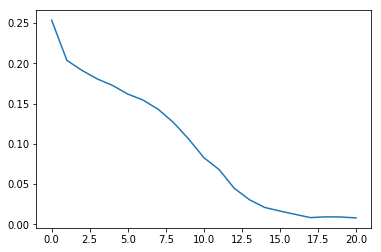

In [158]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)
plt.show()

In [159]:
prediction = test_model(test_loader, model)[2]

In [161]:
prediction_list = [i.item() for m in prediction for i in m ]

In [162]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
f1_score(test_label, prediction_list,average = 'micro') 


0.88659058487874465

In [163]:
test_label.count(0)/len(test_label)

0.9144079885877318

In [164]:
prediction_list.count(1)/len(prediction_list)

0.033523537803138374

In [165]:
recall_score(test_label, prediction_list) 

0.033333333333333333

In [168]:
pd.DataFrame(prediction_list).to_csv('CNN_prediction.csv',index=False)